# Spatial Clustering Algorithm under MEmory Limits (SCAMEL) for Travel-Time Catchments: Illinois

**Author:** Alexander Michels

In this notebook, we will walk through the SCAMEL algorithm for calculating travel-time catchments of hospitals in Illinois.

In [1]:
from collections import Counter
import copy
from disjoint_set import DisjointSet
import geopandas as gpd
import itertools
import json
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
from networkx.algorithms.operators.binary import compose as nx_compose
from numbers import Number  # allows for type hinting of numerics
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pathlib
import time
import tqdm
import uuid

# Table of Contents:

* [Parameters](#params)
* [Data](#data)
* [Calculating Primary Regions](#primary)
* [Merging by Set Relations (Shared Spatial Context)](#set-rel)
* [Merging by Memory](#memory)

# Parameters

For simplicity, I have put the parameters/file paths/etc. in this big `PARAMS` dict. Not all of the parameters/options below are relevant, but they are all given because I used a large PARAM json when running my experiments.

A brief overview of the sections:

* access - parameters related to the accessibility calculation. You'll see projection to do the final plot in and weights to use for E2SFCA
* compute - computational parameters, specifically maximum memory and number of threads for certain sections that are parallelized
* graphml - parameters related to the OSMnx networks, stored in graphml files. Unfortunatly, Github doesn't allow for storing hundreds of gigabytes of graphml files, but the `scripts` folder can help you obtain the graphs yourself.
* output - used for configuring outputs like figure size
* pop - information relating to population data
* region - parameters relating to clustering regions and calculating travel-time catchments
* resource - parameters relating to the resource data (in our case hospitals

In [2]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection": "EPSG:4326"
    },
    "compute": {
        "max_memory" : 16,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/counties/ILCounties/ILCountyShapefile.shp",
        "dir" : "../data/graphml/ilcounties/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/ILCounty-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [12, 18]
    },
    "pop" : {
        "file": "../data/pop/illinois/SVI2018_IL_tract.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 4,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Illinois",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/illinois/IllinoisHospitals.shp"
    }
}

<hr id="data">

# Data

Let's load the hospital data! We will also perform a few checks:

* check that our "key" is actually unique so we can identify each hospital uniquely
* project our data to Contiguous Albers Equal Area Conic Projection: https://epsg.io/102003
* print out the projection and number of hospitals
* view the data with head()

In [3]:
resources = gpd.read_file(PARAMS["resource"]["shapefile"])
assert resources[PARAMS["resource"]["key"]].is_unique
resources = resources.to_crs(PARAMS["region"]["projection"])
print("The geometry is {}".format(resources.crs))
print("There are {} resources represented".format(len(resources)))
resources.head()

The geometry is ESRI:102003
There are 226 resources represented


,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1513,0003460644,UHS HARTGROVE HOSPITAL,5730 WEST ROOSEVELT ROAD,CHICAGO,IL,60644,NOT AVAILABLE,(773) 413-1700,PSYCHIATRIC,...,http://www.hartgrovehospital.com,0005454,NOT AVAILABLE,17,PROPRIETARY,-999,128,NOT AVAILABLE,N,POINT (677706.861 518544.822)
1,1514,0001860612,JESSE BROWN VA MEDICAL CENTER - VA CHICAGO HEA...,820 S DAMEN STREET,CHICAGO,IL,60612,NOT AVAILABLE,(312) 569-8387,MILITARY,...,http://www.chicago.va.gov/,14003F,NOT AVAILABLE,17,GOVERNMENT - FEDERAL,-999,240,NOT AVAILABLE,N,POINT (685088.436 519684.489)
2,1515,0003160463,PALOS COMMUNITY HOSPITAL,12251 SOUTH 80TH AVENUE,PALOS HEIGHTS,IL,60464,NOT AVAILABLE,(708) 923-4000,GENERAL ACUTE CARE,...,http://www.paloscommunityhospital.org,140062,NOT AVAILABLE,17,NON-PROFIT,-999,377,NOT AVAILABLE,Y,POINT (675828.819 496243.670)
3,1516,0003660628,ROSELAND COMMUNITY HOSPITAL,45 W 111TH STREET,CHICAGO,IL,60628,NOT AVAILABLE,(773) 995-3000,GENERAL ACUTE CARE,...,http://www.roselandhospital.org,140068,NOT AVAILABLE,17,NON-PROFIT,-999,115,NOT AVAILABLE,N,POINT (691089.739 500162.084)
4,1517,0002360302,WEST SUBURBAN MEDICAL CENTER,3 ERIE COURT,OAK PARK,IL,60302,NOT AVAILABLE,(708) 383-6200,GENERAL ACUTE CARE,...,http://www.westsuburbanmc.com/Home.aspx,140049,NOT AVAILABLE,17,PROPRIETARY,-999,172,NOT AVAILABLE,N,POINT (676748.773 521277.201)


We can also visualize the data by plotting it with Geopandas:

<AxesSubplot:>

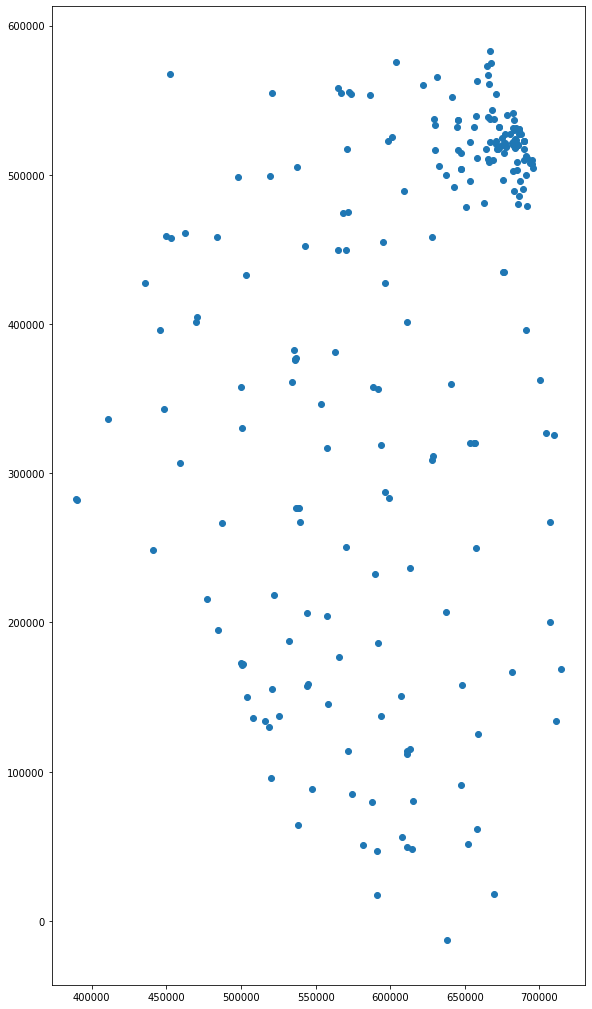

In [4]:
resources.plot(figsize=PARAMS["output"]["figsize"])

Our method for calculating travel-time catchments relies on clustering spatial units (in our case counties) together into "regions." Doing this requires that we have our OSMnx network pulled by county, and data on the geographic bounds of counties so we can see how they relate to our hospitals.

Here we load the shapefile for counties, drop any duplicates, and project the data.

In [5]:
county_shapefiles = gpd.read_file(PARAMS["graphml"]["geo_unit_shapefile"])
county_shapefiles.drop_duplicates(inplace=True, subset=[PARAMS["graphml"]["geo_unit_key"]])
county_shapefiles = county_shapefiles.to_crs(PARAMS["region"]["projection"])
print("There are {} counties represented".format(len(county_shapefiles)))
county_shapefiles.head()

There are 102 counties represented


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((644807.679 431295.144, 645687.311 43..."
1,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((436783.276 363512.862, 436755.241 36..."
2,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((638438.260 499329.590, 638973.311 49..."
3,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((542119.643 147413.564, 543761.494 14..."
4,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((635130.213 537472.688, 635563.062 53..."


Let's plot the data with Geopandas again:

<AxesSubplot:>

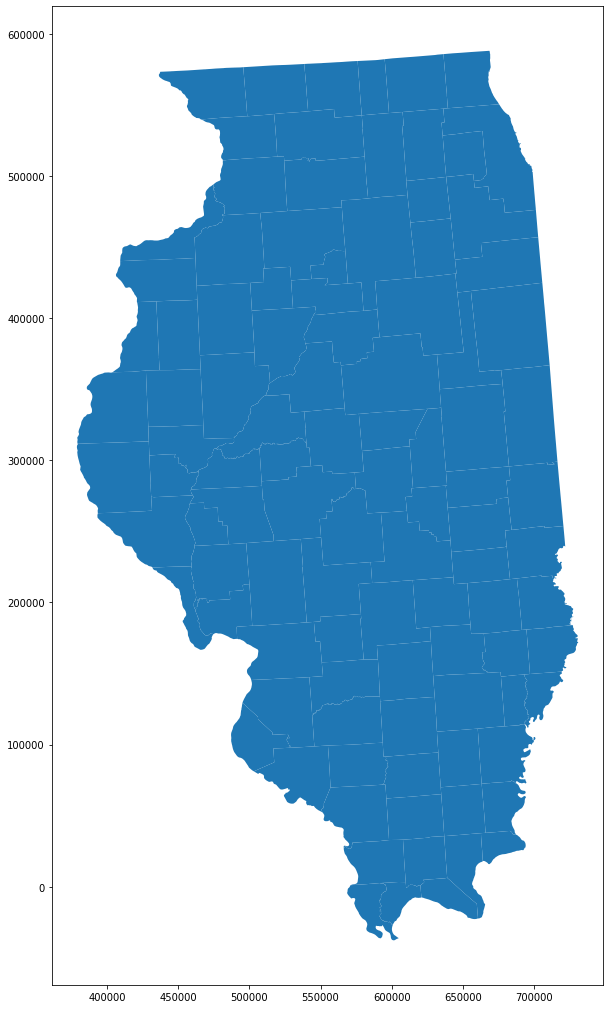

In [6]:
county_shapefiles.plot(figsize=PARAMS["output"]["figsize"])

Our method clusters the road network pieces up to a given memory limit. To do this, we need information on the memory usage of each piece of the network. This was generated with a script in the `scripts` directory if you're interested on the details!

In [7]:
memory_df = pd.read_csv(PARAMS["graphml"]["memory_csv"])
print("There are {} counties represented".format(len(memory_df)))
memory_df.drop_duplicates(inplace=True, subset=[PARAMS["graphml"]["memory_key"]])
memory_df.head()

There are 102 counties represented


,FGEOID,GEOID,NAME,NAMELSAD,GEOID_FILE,Memory Usage (GB)
0,0500000US17001,17001,Adams,Adams,0500000US17001.graphml,0.185344
1,0500000US17003,17003,Alexander,Alexander,0500000US17003.graphml,0.127336
2,0500000US17005,17005,Bond,Bond,0500000US17005.graphml,0.095334
3,0500000US17007,17007,Boone,Boone,0500000US17007.graphml,0.272421
4,0500000US17009,17009,Brown,Brown,0500000US17009.graphml,0.086508


<hr id="primary">

# Calculate Primary Regions

This step uses an over-estimate of the driving-time catchment to determine the pieces of the network necessary for calculating each hospital's travel-time catchment. Since our projection is in meters, we set the buffer radius to ~64km whih is ~40miles. This will contain a 30 minute driving-time catchment even if the driver is going straight at 80mph for the entire 30 minutes.

Let's plot the buffers:

<AxesSubplot:>

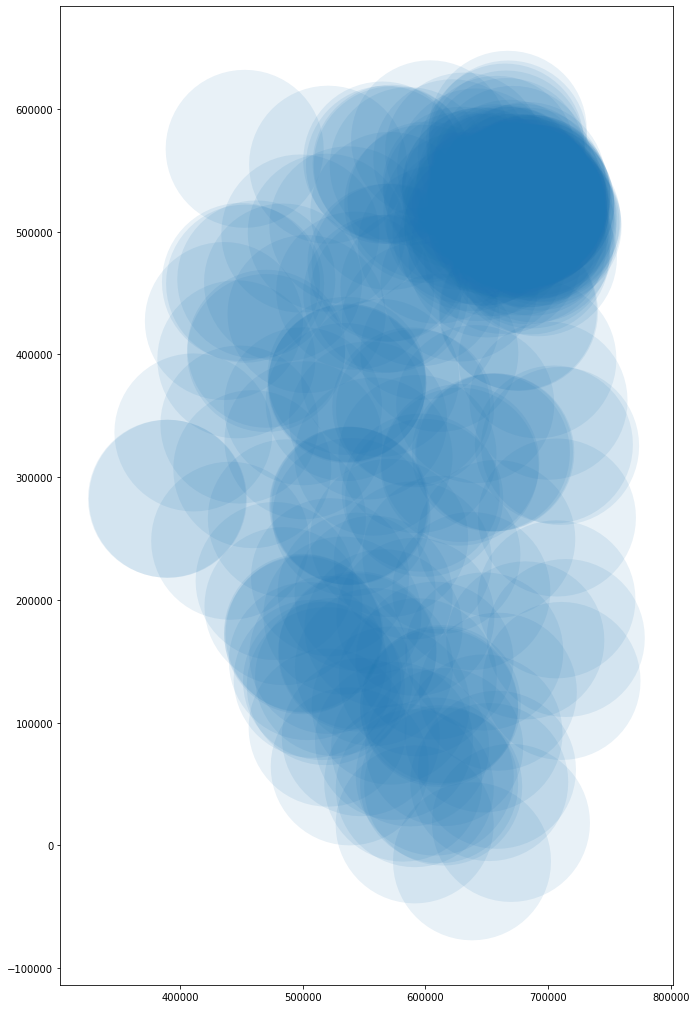

In [8]:
buffers = resources.copy(deep=True)
buffers["geometry"] = buffers.geometry.buffer(PARAMS["region"]["buffer"])
buffers.plot(alpha=0.1, figsize=PARAMS["output"]["figsize"])

Using this information we can calculate the overlap between each hospital's buffer and the counties:

In [9]:
def calculate_primary_regions(resources, buffers, resource_key, census_units, census_units_key):
    """
    For each shape in `buffers`, we calculate it's overlap with the shapes in `census_units`.
    
    Args:
        resources: Geodataframe of resources (hospitals)
        buffers: Geodataframe of resources where geometry is buffers of appropriate size
        resource_key: key/ID field for resources/buffers
        census_units: Geodataframe of spatial units (counties)
        census_units_key: key/ID field for census_units

    Returns:
        Dictionary of id -> set of keys from census_units

    Raises:
        Assertion that the length of each overlap list is greater than zero.
    """
    resource_census_unit_overlap_dict = dict()
    # check if we are going to need the suffixes
    need_suffix = census_units_key in resources.columns
    for index, row in buffers.iterrows():
        poly = buffers.iloc[index:index + 1, :]
        joined_df = gpd.sjoin(poly, census_units)
        if need_suffix:
            _geoids = set(list(joined_df["{}_right".format(census_units_key)]))
        else:
            _geoids = set(list(joined_df[census_units_key]))
        if not len(_geoids) > 0:  # for debugging purposes
            print("We encountered a buffer that doesn't overlap with any shapes:\n")
            print(row)
            print(poly)
            print(joined_df)
            print(_geoids)
        assert len(_geoids) > 0
        resource_census_unit_overlap_dict[list(poly[resource_key])[0]] = _geoids
    return copy.deepcopy(resource_census_unit_overlap_dict)

In [10]:
resource_census_unit_overlap_dict = calculate_primary_regions(resources,
                                                              buffers,
                                                              PARAMS["resource"]["key"],
                                                              county_shapefiles,
                                                              PARAMS["graphml"]["geo_unit_key"])
# resource_census_unit_overlap_dict

This dictionary can be extremely long, so let's look at a small slice of it:

In [11]:
dict(list(resource_census_unit_overlap_dict.items())[0:5])

{'0003460644': {'17031',
  '17043',
  '17063',
  '17089',
  '17091',
  '17093',
  '17097',
  '17111',
  '17197'},
 '0001860612': {'17031',
  '17043',
  '17089',
  '17091',
  '17093',
  '17097',
  '17111',
  '17197'},
 '0003160463': {'17031',
  '17043',
  '17063',
  '17089',
  '17091',
  '17093',
  '17097',
  '17111',
  '17197'},
 '0003660628': {'17031',
  '17043',
  '17063',
  '17089',
  '17091',
  '17093',
  '17097',
  '17197'},
 '0002360302': {'17031',
  '17043',
  '17063',
  '17089',
  '17093',
  '17097',
  '17111',
  '17197'}}

This method performs a *partitioning* of the hospitals (each hospital in one group) and *clustering* of the counties (counties can be in more than one group). After this step we have a partition of singletons meaning that each hospital is in a group by itself. This algorithm also gives us a one-to-one relationship between each partition of hospitals and cluster of counties where the group of counties is sufficient for calculating the travel-time catchments for the corresponding group of hospitals.

A county network will be loaded once for each cluster it is in. Let's visualize how many times each county network is loaded if we used this initial partition!

First we need to count how many times each county is included in a cluster and make that into a dataframe, then we can merge that to our geodataframe and plot:

In [12]:
primary_region_counter = Counter()
for region_id, geoids in resource_census_unit_overlap_dict.items():
    for geoid in geoids:
        primary_region_counter[geoid] += 1
primary_region_df = pd.DataFrame(primary_region_counter.items(), columns=["GEOID", "count"])
primary_region_df.head()

,GEOID,count
0,17031,109
1,17111,97
2,17091,53
3,17197,105
4,17097,99


<AxesSubplot:>

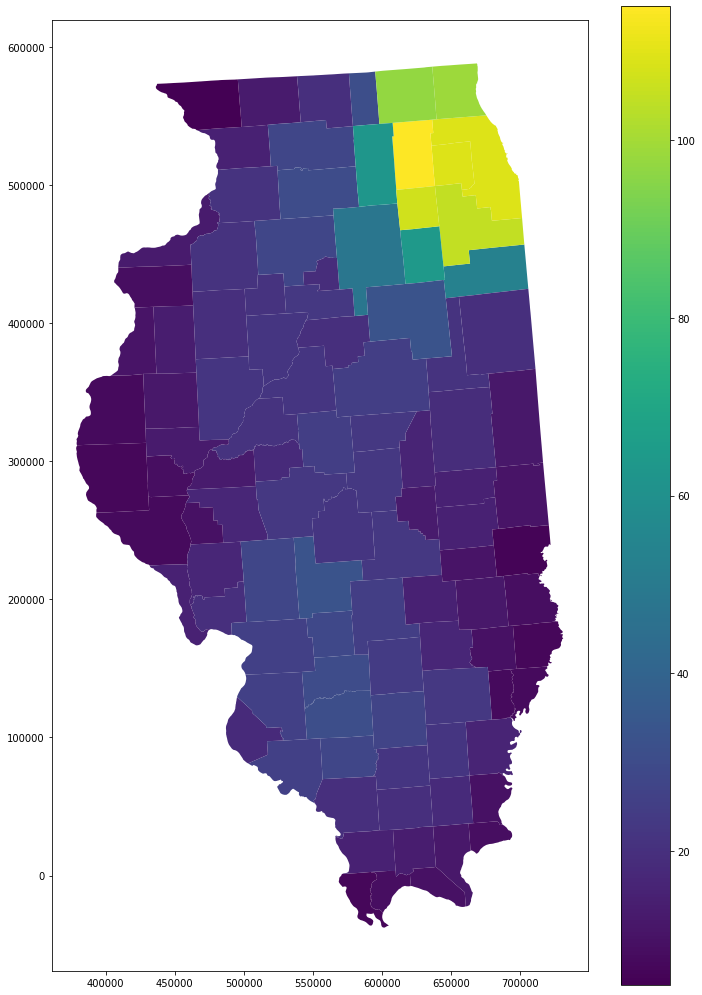

In [13]:
primary_regions = county_shapefiles.copy(deep=True)
primary_regions = primary_regions.merge(primary_region_df, how="left", on="GEOID")
primary_regions.plot(column='count', figsize=PARAMS["output"]["figsize"], legend=True)

<hr id="set-rel">

# Merging by Set Relations (Shared Spatial Context)

Now that we know the necessary counties for each hospital, we want to combine them by shared spatial context. Since we have the spatial context given by a list of counties, we can do this by just comparing the sets of counties. If $A\subseteq B$ which means "A is a subset of B", then A's list of counties are included in B's so we can do the travel-time calculation for A and B with B's set of counties! Note that this means these merges don't add to the memory requirements: B's counties would have to be loaded regardless, but calculating A and B together let's us avoid loading the counties twice.

Let's see what hospitals we should merge:

In [14]:
def combine_regions_by_set_relations(resource_census_unit_overlap_dict, resource_key):
    """
    Combines the list of resources based on set relations.

    Returns:
        DisjointSet object: https://pypi.org/project/disjoint-set/
    """
    _resources = list(resources[resource_key])
    resource_disjoint_set = DisjointSet()  # create a disjoint set
    for r in _resources:
        resource_disjoint_set.find(r)  # add the stuff to the disjoint set
    for key in _resources:
        for okey in _resources:
            val, oval = set(resource_census_unit_overlap_dict[key]), set(resource_census_unit_overlap_dict[okey])
            if val == oval:  # sets are same
                resource_disjoint_set.union(okey, key)
            elif val.issubset(oval):
                resource_disjoint_set.union(key, okey)
            elif oval.issubset(val):
                resource_disjoint_set.union(okey, key)
    return copy.deepcopy(resource_disjoint_set)

In [15]:
disjoint_set_datastructure = combine_regions_by_set_relations(resource_census_unit_overlap_dict, PARAMS["resource"]["key"])

This operation uses a disjoint set data-structure which helps us group together sets of hospitals. Each group is identified by a group "representive" which can be obtained by calling find on the data-structure. Using this, we can find out how many groups of hospitals we have:

In [16]:
set_regions = set([ disjoint_set_datastructure.find(i) for i in list(resources[PARAMS["resource"]["key"]]) ])
print(len(set_regions))
print(list(set_regions)[0:10])

54
['0014662644', '0000161520', '0014062088', '0001261364', '0002661008', '0017362557', '0001562401', '0015161254', '0017762881', '0002762703']


Now that the disjoint set data-structure has told us which hospitals to group together, let's perform that merging on our region to census units and resource to region dictionaries so they are updated:

In [17]:
def calculate_regions_from_disjoint_set(resources, resource_key, resource_disjoint_set):
    """
    Calculate regions using a disjoint set data structure.
    """
    _resources = list(resources[resource_key])
    set_regions = set([resource_disjoint_set.find(i) for i in _resources])
    region_to_census_units_dict = dict()
    resource_to_region_dict = dict()
    for region in set_regions:
        in_region = [i for i in _resources if resource_disjoint_set.find(i) == region]
        region_to_census_units_dict[region] = set(resource_census_unit_overlap_dict[region])
        for resource in in_region:
            resource_to_region_dict[resource] = region
            # we perform a union just in case
            region_to_census_units_dict[region] = region_to_census_units_dict[region].union(resource_census_unit_overlap_dict[resource])
    return region_to_census_units_dict, resource_to_region_dict

In [18]:
region2cu, resource2region = calculate_regions_from_disjoint_set(resources,
                                                                 PARAMS["resource"]["key"],
                                                                 disjoint_set_datastructure)

In [19]:
# region2cu

In [20]:
# resource2region

We can again plot how many clusters each county is in/how many times each county would have to be loaded:

In [21]:
secondary_region_counter = Counter()
for region, counties in region2cu.items():
    for county in counties:
        secondary_region_counter[county] += 1
secondary_region_df = pd.DataFrame(secondary_region_counter.items(), columns=["GEOID", "count"])
secondary_region_df.head()

,GEOID,count
0,17095,12
1,17169,6
2,17129,13
3,17125,12
4,17009,4


<AxesSubplot:>

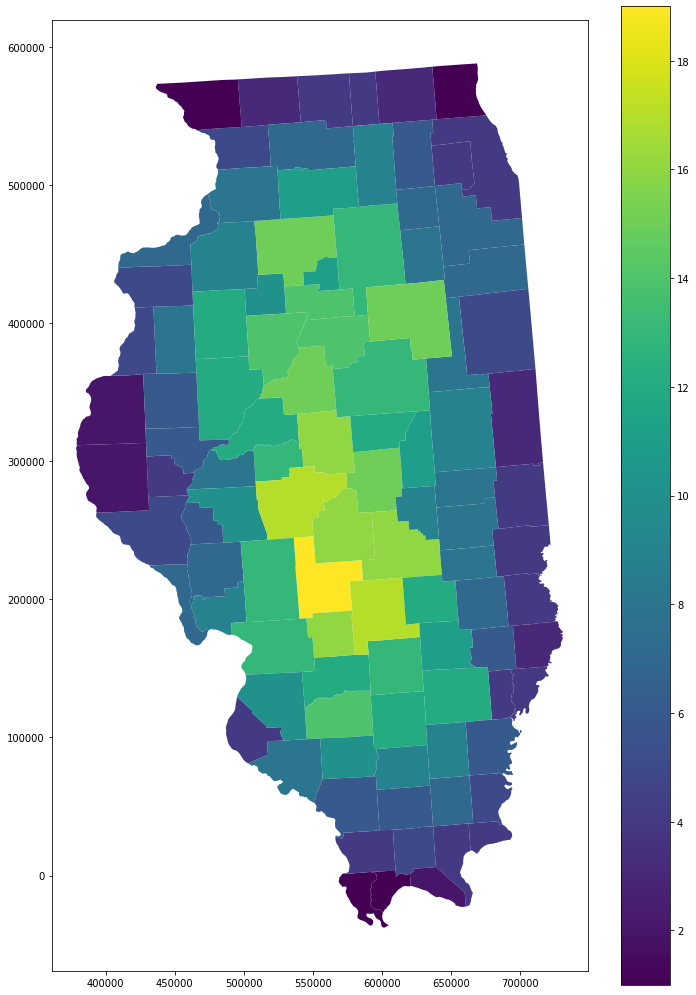

In [22]:
secondary_regions = county_shapefiles.copy(deep=True)
secondary_regions = secondary_regions.merge(secondary_region_df, how="left", on="GEOID")
secondary_regions.plot(column='count', legend=True, figsize=PARAMS["output"]["figsize"])

<hr id="memory">

# Merging by Memory

Now that we have done merging by set relations, further merges may increase the overall memory requirements so we have to consider memory usage from now on. Below are three functions that help us do that:

In [23]:
def calculate_memory_usage(memory_df, memory_key, memory_col, list_of_ids):
    """
    Calculates the memory usage the shapefiles specified by a list of ids.

    Returns:
        float, sum of memory usages for all ids
    """
    return sum([float(memory_df.loc[(memory_df[memory_key] == int(_id)), memory_col]) for _id in list_of_ids])

def calculate_memory_difference(memory_df, memory_key, memory_col, set_a, set_b):
    """
    Calculates the memory usage of the difference between two iterables of file ids.
    
    Returns:
        float, memory usage of A - B
    """
    set_a, set_b = set(set_a), set(set_b)
    _diff = set_a.difference(set_b)
    return calculate_memory_usage(memory_df, memory_key, memory_col, _diff)

def get_max_memory_usage(memory_df, memory_key, memory_col, region_to_census_units_dict):
    """
    Calculates the maximum memory requirement for all regions

    Returns:
        float, maximum memory usage for a set of regions
    """
    return max([calculate_memory_usage(memory_df, memory_key, memory_col, region_to_census_units_dict[key]) for key in region_to_census_units_dict.keys()])


While we are operating under memory limits, the memory limit is not feasible unless we can load all secondary regions within the limit. Why? 

Because secondary regions are by design the set of counties required for *at least one* hospital corresponding to that region. So if our memory limit can't handle that set of counties, we can't calculate that hospital's travel-time catchment within the memory limit.

With that in mind, let's see the maximum memory usage for the current regions:

In [24]:
memory_usage_so_far = get_max_memory_usage(memory_df, 
                                           PARAMS["graphml"]["memory_key"],
                                           PARAMS["graphml"]["memory_column"],
                                           region2cu)
print(memory_usage_so_far)

10.792030208000003


The next line asserts that our memory limit is greater than our current memory usage:

In [25]:
assert memory_usage_so_far < PARAMS["compute"]["max_memory"]

Now that we have passed that bar, we can start merging our regions by memory usage. This uses a greedy algorithm which combined regions with the smallest memory difference until no more merges can be made. This uses the following functions:

In [26]:
def merge_regions(region_a, region_b, region_to_census_units_dict, resource_to_region_dict):
    """
    Merge two regions in the region_to_census_units_dict and resource->region dict (res2reg_dict)

    Args:
        region_a: id of region
        region_b: id of region
        region_to_census_units_dict: dictionary of regions -> census units
        resource_to_region_dict: dictionary of resource -> region
        
    Returns:
        tuple of dicts: (updated region_to_census_units_dict, updated resource_to_region_dict)
    """
    region_to_census_units_dict[region_a] = region_to_census_units_dict[region_a].union(region_to_census_units_dict[region_b])
    del region_to_census_units_dict[region_b]
    # set resources to region_a
    region_b_resources = [key for key, item in resource_to_region_dict.items() if item == region_b]
    for resource in region_b_resources:
        resource_to_region_dict[resource] = region_a
    return region_to_census_units_dict, resource_to_region_dict

def regions_disjoint(region_to_census_units_dict, region_a, region_b):
    """
    Tests if two regions are disjoint

    Args:
        region_to_census_units_dict: dictionary of regions -> census units
        region_a: id of a region
        region_b: id of a region

    Returns:
        boolean, if the set of file ids (counties) is disjoint
    """
    return set(region_to_census_units_dict[region_a]).isdisjoint(region_to_census_units_dict[region_b])

def minimum_combined_memory_region(memory_df, memory_key, memory_col, region_to_census_units_dict, region_a):
    """
    Finds the region (_to_merge_b) that minimizes the combined memory of region_a and _to_merge_b.

    Args:
        memory_df: Dataframe that maps region id to memory usage
        memory_key: key/ID to memory_df
        memory_col: field in memory_df with memory usage
        region_to_census_units_dict: dictionary from region id -> list of file ids (counties)
        region_a: id of a region

    Returns:
        tuple: (float: memory usage, region_a, id of region that has minimum memory difference)
    """
    regions = list(region_to_census_units_dict.keys())
    region_a_mem = calculate_memory_usage(memory_df, memory_key, memory_col, region_to_census_units_dict[region_a])
    _merge_mem, _to_merge_b = 1000000000, -1
    for region_b in regions:
        if region_a != region_b and not regions_disjoint(region_to_census_units_dict, region_a, region_b):
            _mem_diff = calculate_memory_difference(memory_df, memory_key, memory_col, region_to_census_units_dict[region_b], region_to_census_units_dict[region_a])
            if _mem_diff < _merge_mem:
                _merge_mem, _to_merge_b = _mem_diff, region_b
    return (float(_merge_mem + region_a_mem), region_a, _to_merge_b)

def combine_regions_by_memory(region_to_census_units_dict, resource_to_region_dict, MAX_MEMORY_USAGE, threads, memory_df, memory_key, memory_col):
    """
    Combines regions by memory usage.

    Args:
        region_to_census_units_dict: dictionary of regions -> census units
        resource_to_region_dict: dictionary of resource -> region
        MAX_MEMORY_USAGE: memory usage not to exceed
        threads: how many threads to use when finding minimum_combined_memory_region for each region
        memory_df: Dataframe that maps region id to memory usage
        memory_key: key/ID to memory_df
        memory_col: field in memory_df with memory usage

    Returns:
        (updated region_to_census_units_dict, updated resource_to_region_dict)

    Raises:
        assertion that MAX_MEMORY_USAGE is greater than required memory usage
    """
    initial_number_of_regions = len(region_to_census_units_dict)
    how_many_chars = 12  # how many characters of region id to print
    outer_loop_iterations = 0
    STOP_NOW = False
    while not STOP_NOW:
        regions = list(region_to_census_units_dict.keys())
        _start = time.time()
        with mp.Pool(processes=threads) as pool:
            results = pool.starmap(minimum_combined_memory_region, zip(itertools.repeat(memory_df), itertools.repeat(memory_key), itertools.repeat(memory_col), itertools.repeat(region_to_census_units_dict), regions))
        results = sorted(results, key=lambda tup: tup[0])  # sort by first element of tuple
        _how_many_merged = 0
        _seen = set()
        if results[0][0] > MAX_MEMORY_USAGE:  # all merges are too big
            STOP_NOW = True
        for _merge_mem, _to_merge_a, _to_merge_b in results:
            # memory is under the limit, the regions haven't been altered this run
            if _merge_mem <= MAX_MEMORY_USAGE and _to_merge_a not in _seen and _to_merge_b not in _seen:
                print("  New size: {:6.2f}, A: {}, B: {}".format(_merge_mem, str(_to_merge_a).ljust(how_many_chars)[:how_many_chars], str(_to_merge_b).ljust(how_many_chars)[:how_many_chars]))
                _how_many_merged += 1
                _seen.add(_to_merge_a)
                _seen.add(_to_merge_b)
                region_to_census_units_dict, resource_to_region_dict = merge_regions(_to_merge_a, _to_merge_b, region_to_census_units_dict, resource_to_region_dict)
            elif _merge_mem > MAX_MEMORY_USAGE:
                break
        print("(Iter: {}) Time: {:4.2f}, Merged {} regions".format(outer_loop_iterations, time.time() - _start, _how_many_merged))
        outer_loop_iterations += 1
    _dropped = initial_number_of_regions - len(region_to_census_units_dict)
    print("Dropped {} regions ({}--->{})".format(_dropped, initial_number_of_regions, len(region_to_census_units_dict)))
    return copy.deepcopy(region_to_census_units_dict), copy.deepcopy(resource_to_region_dict)

This can take a little while, but each iteration should be faster than the last:

In [27]:
region2cu, resource2region = combine_regions_by_memory(region2cu,
                                                       resource2region,
                                                       PARAMS["compute"]["max_memory"],
                                                       PARAMS["compute"]["threads"],
                                                       memory_df, 
                                                       PARAMS["graphml"]["memory_key"],
                                                       PARAMS["graphml"]["memory_column"],)

  New size:   1.69, A: 0098261231  , B: 0012061282  
  New size:   2.57, A: 0015662930  , B: 0015862859  
  New size:   2.58, A: 0014662644  , B: 0000161520  
  New size:   2.66, A: 0008162521  , B: 0006762526  
  New size:   2.66, A: 0015761443  , B: 0015161254  
  New size:   2.73, A: 0017562454  , B: 0001562401  
  New size:   2.79, A: 0013562016  , B: 0017962626  
  New size:   2.80, A: 0002162864  , B: 0015362812  
  New size:   2.87, A: 0017162568  , B: 0001162565  
  New size:   2.88, A: 0003561603  , B: 0006061554  
  New size:   3.04, A: 0015462812  , B: 0016261747  
  New size:   3.30, A: 0005361801  , B: 0009561938  
  New size:   3.52, A: 0177462269  , B: 0012662062  
  New size:   3.67, A: 0001762801  , B: 0017762881  
  New size:   3.79, A: 0006862246  , B: 0098062471  
  New size:   4.17, A: 0007861764  , B: 0008260970  
  New size:   4.32, A: 0011261354  , B: 0016961356  
  New size:   7.64, A: 0014561068  , B: 0002061081  
  New size:   9.08, A: 0000360435  , B: 000526

Let's again plot how many times each county is loaded with our final regions:

In [28]:
final_region_counter = Counter()
for region, counties in region2cu.items():
    for county in counties:
        final_region_counter[county] += 1
final_region_df = pd.DataFrame(final_region_counter.items(), columns=["GEOID", "count"])
final_region_df.head()

,GEOID,count
0,17155,2
1,17169,2
2,17029,1
3,17061,1
4,17051,1


<AxesSubplot:>

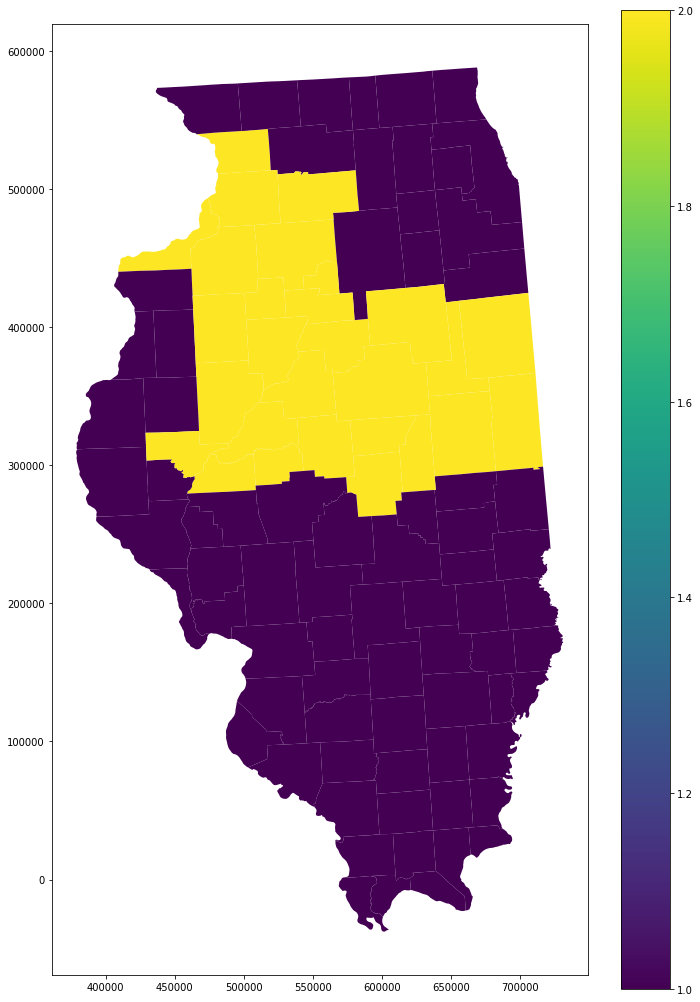

In [29]:
final_regions = county_shapefiles.copy(deep=True)
final_regions = final_regions.merge(final_region_df, how="left", on="GEOID")
final_regions.plot(column='count', legend=True, figsize=PARAMS["output"]["figsize"])

In [30]:
inverted_region_dict = dict()
for region_num, (region, counties) in enumerate(region2cu.items()):
    for county in counties:
        inverted_region_dict[county] = "Region {}".format(region_num)
final_regions = final_regions.merge(pd.DataFrame(inverted_region_dict.items(), columns=["GEOID", "region"]), how="left", on="GEOID")
final_regions.loc[final_regions["count"] > 1, "region"] = "Multiple"
final_regions.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,count,region
0,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((644807.679 431295.144, 645687.311 43...",1,Region 1
1,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((436783.276 363512.862, 436755.241 36...",1,Region 0
2,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((638438.260 499329.590, 638973.311 49...",1,Region 1
3,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((542119.643 147413.564, 543761.494 14...",1,Region 0
4,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((635130.213 537472.688, 635563.062 53...",1,Region 1


We can also visualize what these regions look like:

<AxesSubplot:>

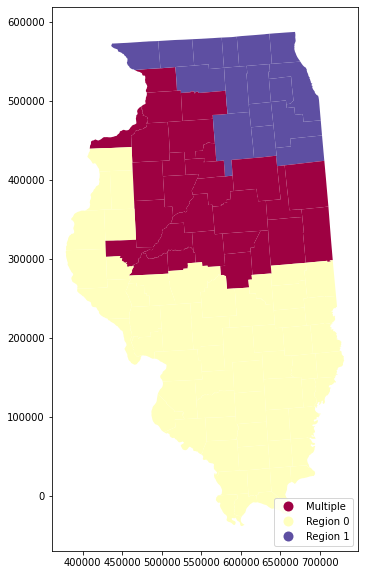

In [31]:
final_regions.plot(column='region', 
                   categorical=True, 
                   cmap='Spectral', 
                   figsize=(18,10),
                   legend=True, 
                   legend_kwds={'loc': 'lower right'})

Now that we have broken down our spatial extent into regions, we can calculate travel-time catchments. This can be a VERY time consuming process and requires OSMnx networks, so we recommend using a compute cluster. The steps are as follows:

* For each region, load and compose (networkx has this functionality) the counties.
  * For each hospital in the region, calculate the egocentric network around the nearest OSM node to the hospital. To convert this into a polygon, calculate the convex hull around the nodes.